Baseline_TF
https://www.kaggle.com/code/ivaneleskin/baseline-tf

In [1]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tqdm import tqdm
import json
import gc
from sklearn.model_selection import train_test_split
# import missingno as msno

from pathlib import Path

2023-02-27 21:14:12.082018: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-27 21:14:12.227952: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-27 21:14:12.683478: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/victor/miniconda3/envs/tf/lib/:/home/victor/miniconda3/envs/tf/lib/:/home/victor/miniconda3/envs/tf/lib/:/home/victor/miniconda3/envs/tf/lib/
2023-02-27 21:14:12.683540: W tensorflow/stream_executor/platfo

In [2]:
DATA_ROOT = Path('..')
DF_TRAIN = DATA_ROOT / 'train.csv'
train = pd.read_csv(DF_TRAIN)

print("train.shape = {} rows, {} cols".format(*train.shape))
train.info()
train.head()


train.shape = 94477 rows, 4 cols
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94477 entries, 0 to 94476
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            94477 non-null  object
 1   participant_id  94477 non-null  int64 
 2   sequence_id     94477 non-null  int64 
 3   sign            94477 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.9+ MB


,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


In [3]:
class CFG:
    data_path = "../"
    quick_experiment = False
    is_training = True
    use_aggregation_dataset = True
    num_classes = 250
    rows_per_frame = 543 

def load_relevant_data_subset_with_imputation(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    data.replace(np.nan, 0, inplace=True)
    n_frames = int(len(data) / CFG.rows_per_frame)
    data = data.values.reshape(n_frames, CFG.rows_per_frame, len(data_columns))
    return data.astype(np.float32)

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / CFG.rows_per_frame)
    data = data.values.reshape(n_frames, CFG.rows_per_frame, len(data_columns))
    return data.astype(np.float32)

def read_dict(file_path):
    path = os.path.expanduser(file_path)
    with open(path, "r") as f:
        dic = json.load(f)
    return dic

In [4]:
train = pd.read_csv(f"{CFG.data_path}train.csv")
label_index = read_dict(f"{CFG.data_path}sign_to_prediction_index_map.json")
index_label = {label_index[key]: key for key in label_index}
train["label"] = train["sign"].map(lambda sign: label_index[sign])

In [5]:
if CFG.is_training:
    print('True')
#     if CFG.use_aggregation_dataset == True:
    try:
        X=  np.load('X_3d.npy')
        y= np.load('y_3d.npy')
    except:
        print('True')
        xs, ys = [], []
        num_frames = np.zeros(len(train))
        for i in tqdm(range(len(train))):
            path = f"{CFG.data_path}{train.iloc[i].path}"
            data = load_relevant_data_subset_with_imputation(path)
            ## Mean Aggregation
            xs.append(np.mean(data, axis=0))
            ys.append(train.iloc[i].label)
            num_frames[i] = data.shape[0]
            if CFG.quick_experiment and i == 4999:
                break
        ## Save number of frames of each training sample for data analysis
        train["num_frames"] = num_frames
        X, y = np.array(xs), np.array(ys)
        print(train["num_frames"].describe())
        train.to_csv("train.csv", index=False)
        np.save('X_3d.npy', X)
        np.save('y_3d.npy', y)

    print(X.shape, y.shape)

True
(94477, 543, 3) (94477,)


In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.GRU(512, return_sequences=True, input_shape=[None,3]),
    tf.keras.layers.GRU(512),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(250, activation="softmax"),
])

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    optimizer='adam',
    metrics=[
        "accuracy",
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top-05-acc"),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name="top-10-acc"),
    ]
)

2023-02-27 21:14:13.764920: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-27 21:14:13.768856: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-27 21:14:13.769021: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-27 21:14:13.769626: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [7]:
if True:
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=27, stratify=y)
    print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
    gc.collect()
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint("model.h5"),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=6,
            restore_best_weights=True,
        ),
    ]
    history = model.fit(X_train, y_train, epochs=120, validation_data=(X_val, y_val), batch_size=512, callbacks=callbacks)
else:
    model = tf.keras.models.load_model("../model.h5")
model.summary()

(75581, 543, 3) (75581,) (18896, 543, 3) (18896,)
Epoch 1/120


2023-02-27 21:14:17.631535: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-02-27 21:14:18.376054: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


148/148 [==============================] - 35s 220ms/step - loss: 5.4936 - accuracy: 0.0044 - top-05-acc: 0.0229 - top-10-acc: 0.0448 - val_loss: 5.4585 - val_accuracy: 0.0059 - val_top-05-acc: 0.0303 - val_top-10-acc: 0.0588
Epoch 2/120
148/148 [==============================] - 33s 222ms/step - loss: 5.4166 - accuracy: 0.0060 - top-05-acc: 0.0303 - top-10-acc: 0.0606 - val_loss: 5.3310 - val_accuracy: 0.0061 - val_top-05-acc: 0.0312 - val_top-10-acc: 0.0640
Epoch 3/120
148/148 [==============================] - 33s 223ms/step - loss: 5.2689 - accuracy: 0.0099 - top-05-acc: 0.0464 - top-10-acc: 0.0885 - val_loss: 5.1186 - val_accuracy: 0.0165 - val_top-05-acc: 0.0692 - val_top-10-acc: 0.1303
Epoch 4/120
148/148 [==============================] - 33s 222ms/step - loss: 5.0576 - accuracy: 0.0173 - top-05-acc: 0.0795 - top-10-acc: 0.1458 - val_loss: 4.9886 - val_accuracy: 0.0268 - val_top-05-acc: 0.1016 - val_top-10-acc: 0.1683
Epoch 5/120
148/148 [==============================] - 33s 2

148/148 [==============================] - 33s 222ms/step - loss: 2.3500 - accuracy: 0.3817 - top-05-acc: 0.7204 - top-10-acc: 0.8221 - val_loss: 2.4189 - val_accuracy: 0.3999 - val_top-05-acc: 0.7151 - val_top-10-acc: 0.8066
Epoch 36/120
148/148 [==============================] - 33s 225ms/step - loss: 2.3188 - accuracy: 0.3886 - top-05-acc: 0.7276 - top-10-acc: 0.8238 - val_loss: 2.3826 - val_accuracy: 0.4079 - val_top-05-acc: 0.7145 - val_top-10-acc: 0.8058
Epoch 37/120
148/148 [==============================] - 33s 223ms/step - loss: 2.2808 - accuracy: 0.3969 - top-05-acc: 0.7335 - top-10-acc: 0.8298 - val_loss: 2.4283 - val_accuracy: 0.3994 - val_top-05-acc: 0.7143 - val_top-10-acc: 0.8046
Epoch 38/120
148/148 [==============================] - 33s 224ms/step - loss: 2.2465 - accuracy: 0.4040 - top-05-acc: 0.7409 - top-10-acc: 0.8337 - val_loss: 2.3762 - val_accuracy: 0.4130 - val_top-05-acc: 0.7194 - val_top-10-acc: 0.8092
Epoch 39/120
148/148 [==============================] - 3

148/148 [==============================] - 33s 226ms/step - loss: 1.5755 - accuracy: 0.5619 - top-05-acc: 0.8461 - top-10-acc: 0.9040 - val_loss: 2.4235 - val_accuracy: 0.4728 - val_top-05-acc: 0.7396 - val_top-10-acc: 0.8110
Epoch 70/120
148/148 [==============================] - 33s 223ms/step - loss: 1.5524 - accuracy: 0.5683 - top-05-acc: 0.8489 - top-10-acc: 0.9063 - val_loss: 2.4318 - val_accuracy: 0.4662 - val_top-05-acc: 0.7340 - val_top-10-acc: 0.8084
Epoch 71/120
148/148 [==============================] - 33s 224ms/step - loss: 1.5347 - accuracy: 0.5709 - top-05-acc: 0.8513 - top-10-acc: 0.9072 - val_loss: 2.4573 - val_accuracy: 0.4669 - val_top-05-acc: 0.7377 - val_top-10-acc: 0.8123
Epoch 72/120
148/148 [==============================] - 33s 221ms/step - loss: 1.5192 - accuracy: 0.5764 - top-05-acc: 0.8532 - top-10-acc: 0.9094 - val_loss: 2.4631 - val_accuracy: 0.4699 - val_top-05-acc: 0.7341 - val_top-10-acc: 0.8115
Epoch 73/120
148/148 [==============================] - 3

In [8]:
import matplotlib.pyplot as plt
import numpy as np

print(history.history.keys())

dict_keys(['loss', 'accuracy', 'top-05-acc', 'top-10-acc', 'val_loss', 'val_accuracy', 'val_top-05-acc', 'val_top-10-acc'])


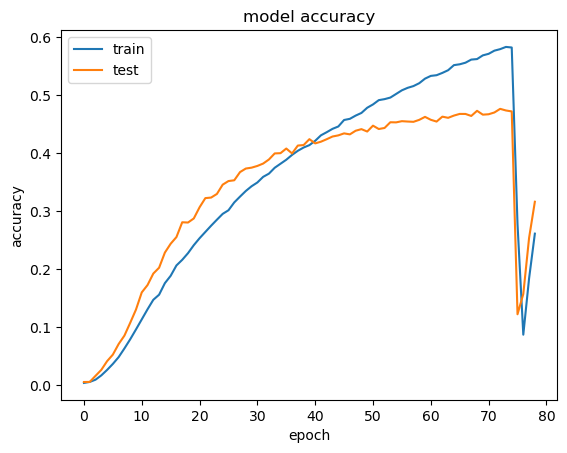

In [9]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

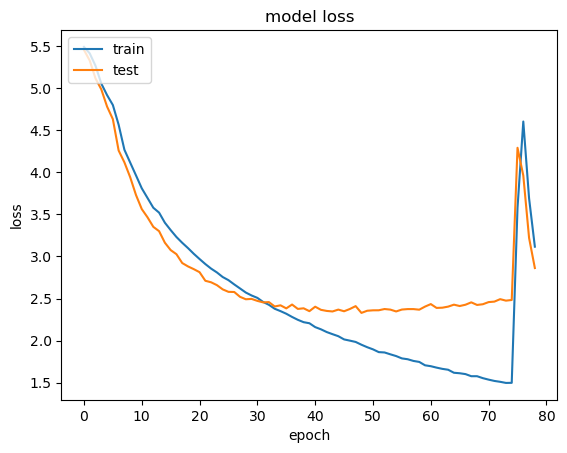

In [10]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
def get_model():
    return model

In [12]:
get_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 512)         794112    
                                                                 
 gru_1 (GRU)                 (None, 512)               1575936   
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [13]:
inputs = tf.keras.Input((543, 3), dtype=tf.float32, name="inputs")
x = tf.where(tf.math.is_nan(inputs), tf.zeros_like(inputs), inputs)
x = tf.reduce_mean(x, axis=0, keepdims=True)

# for i in range(1, len(model.layers)):
x = model.layers[0](x)
x = model.layers[1](x)
x = model.layers[2](x)

In [14]:
def get_inference_model(model):
    inputs = tf.keras.Input((543, 3), dtype=tf.float32, name="inputs")
    x = tf.where(tf.math.is_nan(inputs), tf.zeros_like(inputs), inputs)
    x = tf.reduce_mean(x, axis=0, keepdims=True)
    
    for i in range(0, len(model.layers)):
        x = model.layers[i](x)
    output = tf.keras.layers.Activation(activation="linear", name="outputs")(x)
    inference_model = tf.keras.Model(inputs=inputs, outputs=output) 
    inference_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
    
    return inference_model

In [15]:
inference_model = get_inference_model(model)
inference_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 543, 3)]     0           []                               
                                                                                                  
 tf.math.is_nan_1 (TFOpLambda)  (None, 543, 3)       0           ['inputs[0][0]']                 
                                                                                                  
 tf.zeros_like_1 (TFOpLambda)   (None, 543, 3)       0           ['inputs[0][0]']                 
                                                                                                  
 tf.where_1 (TFOpLambda)        (None, 543, 3)       0           ['tf.math.is_nan_1[0][0]',       
                                                                  'tf.zeros_like_1[0][0]',    

In [16]:
converter = tf.lite.TFLiteConverter.from_keras_model(inference_model)
tflite_model = converter.convert()
model_path = "model.tflite"
# Save the model.
with open(model_path, 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp_0m9d7mv/assets


INFO:tensorflow:Assets written to: /tmp/tmp_0m9d7mv/assets
2023-02-27 21:57:54.504740: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-02-27 21:57:54.504784: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-02-27 21:57:54.505445: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_0m9d7mv
2023-02-27 21:57:54.520873: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-02-27 21:57:54.520913: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_0m9d7mv
2023-02-27 21:57:54.558263: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-02-27 21:57:54.567640: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-02-27 21:57:54.655731: I tensorflow/cc/saved_model/loader.cc:213] Running initializatio

In [17]:
import tflite_runtime.interpreter as tflite
interpreter = tflite.Interpreter(model_path)
found_signatures = list(interpreter.get_signature_list().keys())
prediction_fn = interpreter.get_signature_runner("serving_default")
corr = 0
wrong = []
for i in tqdm(range(100)):
    frames = load_relevant_data_subset(f'../{train.iloc[i].path}')
    output = prediction_fn(inputs=frames)
    sign = np.argmax(output["outputs"])
    if index_label[sign] == train.iloc[i].sign:
        corr += 1
    else:
        wrong.append((index_label[sign], train.iloc[i].sign, train.iloc[i].path))

    #     print(f"Predicted label: {index_label[sign]}, Actual Label: {train.iloc[i].sign}")


    total = i

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.18it/s]


In [18]:
r = f'''
{total=}
{corr=}\t Percent: {corr/total:%}
'''
print(r)


total=99
corr=63	 Percent: 63.636364%



In [19]:
wrongs = pd.DataFrame(data=wrong, columns=['pred','true','path'])
wrongs.groupby('pred').count().reset_index().sort_values('true')

,pred,true,path
0,boat,1,1
29,snow,1,1
28,sleepy,1,1
27,sleep,1,1
26,red,1,1
25,rain,1,1
24,puppy,1,1
23,pool,1,1
22,police,1,1
21,please,1,1
